# Transcription Factor Classifier

In [8]:
from nn import NeuralNetwork
import numpy as np
from typing import List, Dict, Tuple, Union
from numpy.typing import ArrayLike
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import pandas as pd
from TFC_io import read_text_file, read_fasta_file
from preprocess import sample_seqs, one_hot_encode_seqs
import matplotlib.pyplot as plt

### Read in Rap1 motif examples

In [2]:
rap1_motifs = read_text_file("../data/rap1-lieb-positives.txt")
labels = [True for i in range(len(rap1_motifs))] #generate labels, where True = positive

### Read in negative example from yeast

In [3]:
yeast_neg = read_fasta_file("../data/yeast-upstream-1k-negative.fa")
labels = labels + [False for i in range(len(yeast_neg))]

### Explain Sampling Scheme
I chose to use oversampling to correct the class imbalance in the data by resampling the positive class with replacement until it had the same number of observations as the negative class. While this can make the classification model prone to ovefitting, it prevents information loss and avoids an extremely small sample size if we were to downsample the yeast data to the size of the rap1_motifs.

### Implement sampling scheme

In [4]:
seqs = rap1_motifs + yeast_neg #combine the two lists of seqs
new_seqs, new_labels = sample_seqs(seqs, labels) #fix class imbalance

### Generate training and validation sets

In [5]:
#use a 70/30 train/test split
X_train, X_val, y_train, y_val = train_test_split(new_seqs, new_labels, test_size=0.3, random_state=42)

### One hot encode the sequences in the training and test sets

In [6]:
X_train_encoded = one_hot_encode_seqs(X_train)
X_val_encoded = one_hot_encode_seqs(X_val)

### Define plotting function so loss history of neural network can be visualized

In [9]:
def plot_loss_history(per_epoch_loss_train, per_epoch_loss_val):
    """
    Plots the loss history after training is complete.
    """
    loss_hist = per_epoch_loss_train
    loss_hist_val = per_epoch_loss_val
    assert len(loss_hist) > 0, "Need to run training before plotting loss history"
    fig, axs = plt.subplots(2, figsize=(8,8))
    fig.suptitle('Loss History')
    axs[0].plot(np.arange(len(loss_hist)), loss_hist)
    axs[0].set_title('Training Loss')
    axs[1].plot(np.arange(len(loss_hist_val)), loss_hist_val)
    axs[1].set_title('Validation Loss')
    plt.xlabel('Steps')
    axs[0].set_ylabel('Train Loss')
    axs[1].set_ylabel('Val Loss')
    fig.tight_layout()

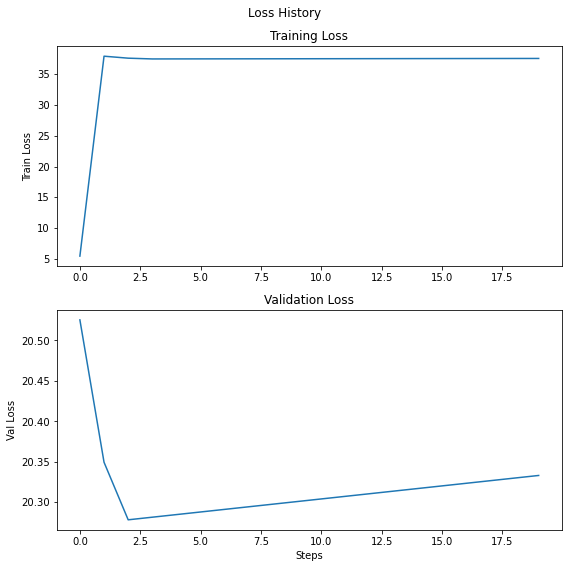

In [14]:
plot_loss_history(per_epoch_loss_train, per_epoch_loss_val)

### Train a neural network
I will be exploring some hyperparameters in the next few code chunks

Number of hidden layers = 1, hidden layer activation function = relu:

In [8]:
#start with a neural network with only 1 hidden layer with 5 nodes and go from there (final output should stem from a sigmoid function)
nn_arch = [{'input_dim': 2, 'output_dim': 3, 'activation': 'relu'}, 
           {'input_dim': 3, 'output_dim': 2, 'activation': 'sigmoid'}]
classifier = NeuralNetwork(nn_arch, 
                          lr=0.1, 
                          seed=42, 
                          batch_size=15, 
                          epochs=100, 
                          loss_function = "binary cross entropy")
#make sure to expand the dimensions of the input data and convert both input and output data to arrays
X_train_encoded = np.array(np.expand_dims(X_train_encoded, axis = 1))
X_val_encoded = np.array(np.expand_dims(X_val_encoded, axis = 1))
y_train = np.array(y_train)
y_val = np.array(y_val)

#fit the neural network
classifier.fit(X_train_encoded, y_train, X_val_encoded, y_val)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 15 is different from 2)

In [2]:
#start with a neural network with only 1 hidden layer with 5 nodes and go from there (final output should stem from a sigmoid function)
nn_arch = [{'input_dim': 2, 'output_dim': 3, 'activation': 'relu'}, 
           {'input_dim': 3, 'output_dim': 2, 'activation': 'sigmoid'}]
classifier = NeuralNetwork(nn_arch, 
                          lr=0.1, 
                          seed=42, 
                          batch_size=15, 
                          epochs=100, 
                          loss_function = "mean squared error")
#make sure to expand the dimensions of the input data and convert both input and output data to arrays
#X_train_encoded = np.array(np.expand_dims(X_train_encoded, axis = 1))
#X_val_encoded = np.array(np.expand_dims(X_val_encoded, axis = 1))
#y_train = np.array(y_train)
#y_val = np.array(y_val)
classifier._param_dict

{'W1': array([[ 0.04967142, -0.01382643],
        [ 0.06476885,  0.15230299],
        [-0.02341534, -0.0234137 ]]),
 'b1': array([[ 0.15792128],
        [ 0.07674347],
        [-0.04694744]]),
 'W2': array([[ 0.054256  , -0.04634177, -0.04657298],
        [ 0.02419623, -0.19132802, -0.17249178]]),
 'b2': array([[-0.05622875],
        [-0.10128311]])}

In [12]:
(classifier._param_dict["W1"]).shape[1]

2

In [3]:
tempX_train = np.array([[1,2],
                       [3,4],
                       [5,6],
                       [7,8],
                       ])
output, cache = classifier.forward(tempX_train)
print(output)
print(cache)
#check this manually!

[[0.48322134 0.45455472]
 [0.47916976 0.43447566]
 [0.47512091 0.41460935]
 [0.47107534 0.39501693]]
{'A0': array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8]]), 'A1': array([[0.17993984, 0.4461183 , 0.        ],
       [0.25162981, 0.88026198, 0.        ],
       [0.32331978, 1.31440566, 0.        ],
       [0.39500975, 1.74854933, 0.        ]]), 'Z1': array([[ 0.17993984,  0.4461183 , -0.11719017],
       [ 0.25162981,  0.88026198, -0.21084823],
       [ 0.32331978,  1.31440566, -0.3045063 ],
       [ 0.39500975,  1.74854933, -0.39816437]]), 'A2': array([[0.48322134, 0.45455472],
       [0.47916976, 0.43447566],
       [0.47512091, 0.41460935],
       [0.47107534, 0.39501693]]), 'Z2': array([[-0.06713985, -0.18228418],
       [-0.08336922, -0.26361341],
       [-0.0995986 , -0.34494263],
       [-0.11582797, -0.42627186]])}


In [4]:
### Check the backprop methods
grad_dict = classifier.backprop(tempX_train, output, cache)
grad_dict

{'dW2': array([[0.09559478, 0.36484993, 0.        ],
        [0.09310391, 0.3545925 , 0.        ]]),
 'db2': array([[0.33260966],
        [0.32510943]]),
 'dW1': array([[ 8., 10.],
        [ 8., 10.],
        [ 0.,  0.]]),
 'db1': array([[2.],
        [2.],
        [0.]])}

In [5]:
classifier._param_dict

{'W1': array([[ 0.04967142, -0.01382643],
        [ 0.06476885,  0.15230299],
        [-0.02341534, -0.0234137 ]]),
 'b1': array([[ 0.15792128],
        [ 0.07674347],
        [-0.04694744]]),
 'W2': array([[ 0.054256  , -0.04634177, -0.04657298],
        [ 0.02419623, -0.19132802, -0.17249178]]),
 'b2': array([[-0.05622875],
        [-0.10128311]])}

In [13]:
#fit the neural network
nn_arch = [{'input_dim': 2, 'output_dim': 3, 'activation': 'relu'}, 
           {'input_dim': 3, 'output_dim': 2, 'activation': 'sigmoid'}]
tempX_train = np.array([[1,2],
                       [3,4],
                       [5,6],
                       [7,8],
                       ])
X_train_encoded = tempX_train
y_train = tempX_train

X_val_encoded = np.array([[0.9, 1.9],
                         [2.9, 3.7],
                         [4.9, 5.9],
                         [6.9, 7.8]])
y_val = X_val_encoded

classifier2 = NeuralNetwork(nn_arch, 
                          lr=0.01, 
                          seed=42, 
                          batch_size=3, 
                          epochs=20, 
                          loss_function = "mean squared error")

per_epoch_loss_train, per_epoch_loss_val = classifier2.fit(X_train_encoded, y_train, X_val_encoded, y_val)

In [14]:
0.1*grad_dict['db' + str(1)]

array([[0.1],
       [0.1],
       [0.1],
       [0.1]])

In [13]:
grad_dict['db' + str(1)]

array([[1.],
       [1.],
       [1.],
       [1.]])

In [8]:
A1 = cache['A1']

In [10]:
np.dot(A1, 1-A1)

ValueError: shapes (4,3) and (4,3) not aligned: 3 (dim 1) != 4 (dim 0)

In [11]:
A1

array([[0.17993984, 0.4461183 , 0.        ],
       [0.25162981, 0.88026198, 0.        ],
       [0.32331978, 1.31440566, 0.        ],
       [0.39500975, 1.74854933, 0.        ]])

In [12]:
1-A1

array([[ 0.82006016,  0.5538817 ,  1.        ],
       [ 0.74837019,  0.11973802,  1.        ],
       [ 0.67668022, -0.31440566,  1.        ],
       [ 0.60499025, -0.74854933,  1.        ]])

In [6]:
classifier._mean_squared_error(tempX_train, output)

21.732094297303906

In [7]:
classifier._mean_squared_error_backprop(tempX_train, output)

array([[-0.25838933, -0.77272264],
       [-1.26041512, -1.78276217],
       [-2.26243954, -2.79269532],
       [-3.26446233, -3.80249154]])

In [11]:
y = np.array([1,2,3,4])

In [17]:
type(y.shape)

tuple

In [3]:
#start with a neural network with only 1 hidden layer with 5 nodes and go from there (final output should stem from a sigmoid function)
nn_arch = [{'input_dim': 2, 'output_dim': 3, 'activation': 'relu'}, 
           {'input_dim': 3, 'output_dim': 2, 'activation': 'sigmoid'}]
classifier = NeuralNetwork(nn_arch, 
                          lr=0.1, 
                          seed=42, 
                          batch_size=15, 
                          epochs=100, 
                          loss_function = "mean squared error")

In [4]:
classifier._param_dict

{'W1': array([[ 0.04967142, -0.01382643],
        [ 0.06476885,  0.15230299],
        [-0.02341534, -0.0234137 ]]),
 'b1': array([[ 0.15792128],
        [ 0.07674347],
        [-0.04694744]]),
 'W2': array([[ 0.054256  , -0.04634177, -0.04657298],
        [ 0.02419623, -0.19132802, -0.17249178]]),
 'b2': array([[-0.05622875],
        [-0.10128311]])}

In [ ]:
for idx, layer in enumerate(self.arch):
    #print(layer_idx)
    layer_idx = idx+1

    curr_activation = layer['activation'] #get activation function type for the current layer
    param_dict = self._param_dict #get current parameters

    W_curr = param_dict['W' + str(layer_idx)] #get current weights (which on first pass will be randomly initialized)
    b_curr = param_dict['b' + str(layer_idx)] #get current bias terms

    A_curr,Z_curr = self._single_forward(W_curr, b_curr, A_prev, curr_activation)

    cache["A"+str(layer_idx)] = A_curr #store current A matrix in cache dictionary
    cache["Z"+str(layer_idx)] = Z_curr #store current Z matrix in cache dictionary


    #update variables for next iteration
    A_prev = A_curr

output = A_curr #output should be final A values of corresponding to output layer

return output,cache

In [13]:
for idx, layer in enumerate(classifier.arch):
    print("idx: " + str(idx) + ", layer: " + str(layer))

idx: 0, layer: {'input_dim': 2, 'output_dim': 3, 'activation': 'relu'}
idx: 1, layer: {'input_dim': 3, 'output_dim': 2, 'activation': 'sigmoid'}


In [17]:
W1 = classifier._param_dict['W1']
b1 = classifier._param_dict['b1']
b1

array([[ 0.15792128],
       [ 0.07674347],
       [-0.04694744]])

In [16]:
Z_curr_nob = np.matmul(np.transpose(W1),tempX_train)
Z_curr_nob

array([[0.12690129, 0.21792622],
       [0.32601405, 0.44107691]])

In [22]:
Z_curr_nob = np.matmul(W1,tempX_train)
Z_curr_nob

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)

In [5]:
temp = np.array([[1,2,3],
                [4,5,6]])

In [6]:
temp.T

array([[1, 4],
       [2, 5],
       [3, 6]])